In [15]:
import os 
from langchain.chat_models import init_chat_model 
llm=init_chat_model("groq:llama-3.1-8b-instant")
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x0000014BFC5F4150>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000014BFC531150>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [16]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool 
from typing_extensions import TypedDict 

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END 
from langgraph.graph.message import add_messages 
from langgraph.prebuilt import ToolNode, tools_condition 

from langgraph.types import Command, interrupt 

class State(TypedDict): 
    messages: Annotated[list,add_messages]
    
graph_builder=StateGraph(State) 

@tool 
def human_assistance(query:str)->str: 
    """Request assistance from a human""" 
    human_response=interrupt({"query":query})
    return human_response['data'] 

tool=TavilySearch(max_results=2) 
tools=[tool,human_assistance]
llm_with_tools=llm.bind_tools(tools)

def chatbot(state:State): 
    message=llm_with_tools.invoke(state['messages']) 
    return {"messages":[message]} 

graph_builder.add_node("chatbot",chatbot) 

tool_node=ToolNode(tools=tools)
graph_builder.add_node("tools",tool_node)


graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge(START,"chatbot")



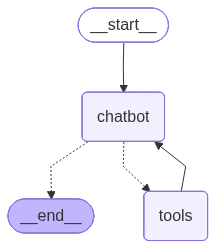

In [17]:
memory=MemorySaver()

graph=graph_builder.compile(checkpointer=memory)
graph

In [18]:
user_input="I need some expert advice and assistance on investing in stocks. could you request assistance for me?"
config={"configurable":{"thread_id":"1"}} 

events=graph.stream(
    {"messages":user_input},config,stream_mode="values"
)
for event in events:
    if 'messages' in event:
        event['messages'][-1].pretty_print()

================================ Human Message =================================

I need some expert advice and assistance on investing in stocks. could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (20hffdwy7)
 Call ID: 20hffdwy7
  Args:
    query: Expert advice on investing in stocks
================================== Ai Message ==================================
Tool Calls:
  human_assistance (20hffdwy7)
 Call ID: 20hffdwy7
  Args:
    query: Expert advice on investing in stocks


In [21]:
human_response="Sure, I recommend diversifying your portfolio across different sectors and considering index funds for long-term growth."

human_command=Command(resume={"data":human_response})

events=graph.stream(human_command,config,stream_mode="values")
for event in events:
    if 'messages' in event:
        event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: human_assistance

Sure, I recommend diversifying your portfolio across different sectors and considering index funds for long-term growth.
================================== Ai Message ==================================
Tool Calls:
  tavily_search (mcvwa23ch)
 Call ID: mcvwa23ch
  Args:
    query: Stock market investing tips
    topic: finance
================================= Tool Message =================================
Name: tavily_search

{"query": "Stock market investing tips", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.bloomberg.com/graphics/2026-investment-outlooks/", "title": "Here's (Almost) Everything Wall Street Expects in 2026", "content": "*   [Software Updates](https://www.bloomberg.com/professional/support/customer-support/software-updates/?utm_source=bloomberg-menu&utm_medium=graphics). *   [About](https://www.bloomberg.com/company/?ut